In [1]:
"""
Created on Mon Jan 15 17:45:41 2024

Convolution neural network for digit recognition on mnist dataset

@author: ganchenko
"""

from tqdm import tqdm
import numpy as np
import pandas as pd
import seaborn as sns
import random
from matplotlib import pyplot as plt 
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split

from sklearn.metrics import confusion_matrix
from matplotlib.colors import LogNorm

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


# Usefull function

In [2]:
def compute_accuracy(predictions, y):
    """Computes the accuracy of predictions against the gold labels, y."""
    return np.mean(np.equal(predictions.numpy(), y.numpy()))

def plot_digits(X, img_pix, n=1, labels_predict=np.array([None]), labels_act=np.array([None]), rnd=True):
    """
    Plot n*n random digits from dataset
    
    Args:
        X -  (num, img_pix*img_pix), array of digits
        img_pix - int, size of the digit img_pix*img_pix
        n - int, n is a number of columns and rows
        labels_predicted - (num, ) of int or str with predicted labels
        labels_act - (num, ) of int or str with actual labels
        rnd - Boolean, random chosing of samples
    Returns:
        nothing
    """
    plt.figure(figsize=[1.5*n, 1.5*n])
   
    for i in range(n*n):
        plt.subplot(n , n, i+1)
        if rnd:
            indx=random.randint(0, X.shape[0]-1)
        else:
            indx=i
        dig=X[indx, :].reshape(img_pix, img_pix)
        plt.imshow(dig, cmap='gray_r')
        plt.axis('off')
        str_title=''
        if labels_act[0]!=None: str_title+=' Act_num: '+str(labels_act[indx])+', \n'
        if labels_predict[0]!=None: str_title+='Pre_num: '+str(labels_predict[indx])
        plt.title(str_title)
            
    plt.tight_layout()        
    plt.show()       
    
class Flatten(nn.Module):
    """A custom layer that views an input as 1D."""

    def forward(self, input):
        return input.view(input.size(0), -1)

class ImageDataset(Dataset):

    def __init__(self, images, labels=None, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx] 
        image = torch.from_numpy(image).float()
        image = image.view(1, 28, 28) 
    
        if self.labels is not None:  
            label = torch.tensor(self.labels[idx])
            return image, label
        return image

# Training procedure

In [3]:
# Training Procedure
def train_model(train_data, dev_data, model, device=torch.device('cpu'), lr=0.01, momentum=0.9, nesterov=False, n_epochs=20,  batch_size=32):
    """Train a model for N epochs given data and hyper-params."""

    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, nesterov=nesterov)
    train_accuracies = []
    val_accuracies =[]
    for epoch in range(1, n_epochs+1):
        print("-------------\nEpoch {}:\n".format(epoch))

        # Run **training***
        loss, acc = run_epoch(train_data, model.train(), optimizer, device, batch_size)
        print('Train loss: {:.6f} | Train accuracy: {:.6f}'.format(loss, acc))
        train_accuracies.append(acc)

        # Run **validation**
        val_loss, val_acc = run_epoch(dev_data, model.eval(), optimizer, device, batch_size)
        print('Val loss:   {:.6f} | Val accuracy:   {:.6f}'.format(val_loss, val_acc))
        val_accuracies.append(val_acc)
        # Save model
        torch.save(model, 'mnist_cnn.pt')
    return train_accuracies, val_accuracies

def run_epoch(data, model, optimizer, device=torch.device('cpu'),  batch_size=32):
    """Train model for one pass of train data, and return loss, acccuracy"""
   
    losses = []
    batch_accuracies = []
    is_training = model.training

    # batchify data
    #indices permutation in training set for a better SGD estimation
    if is_training: 
        data_batched = DataLoader(data, batch_size=batch_size, shuffle=True)
    else:
        data_batched = DataLoader(data, batch_size=batch_size)
        
    # Iterate through batches
    for batch in tqdm(data_batched):
        
        x, y = batch
        # Move data to the specified device (GPU or CPU)
        x, y = x.to(device), y.to(device)
        out = model(x)

        predictions = torch.argmax(out, dim=1)
        batch_accuracies.append(compute_accuracy(predictions, y))

        loss = F.cross_entropy(out, y)
        losses.append(loss.data.item())

        if is_training:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Calculate epoch level scores
    avg_loss = np.mean(losses)
    avg_accuracy = np.mean(batch_accuracies)
    return avg_loss, avg_accuracy

# Import data

In [4]:
all_data = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
y=all_data.label.to_numpy(dtype='long')
img_pix=28

X=all_data.drop(['label'], axis=1, inplace=False).to_numpy(dtype='float')
# Scaling data to [0, 1]
X=X/np.max(X)
#plot_digits(X, img_pix, 3, labels_act=y)

#split data into training and validation parts
X_set = ImageDataset(X, y)
X_train_set, X_dev_set=random_split(X_set, [0.9, 0.1], generator=torch.Generator().manual_seed(42))

# Training model

In [5]:
#%% Train model

#################################
## Model specification
model = nn.Sequential(
          nn.Conv2d(1, 32, (3, 3)),
          nn.ReLU(),
          nn.MaxPool2d((2, 2)),
          nn.Conv2d(32, 64, (3, 3)),
          nn.ReLU(),
          nn.MaxPool2d((2, 2)),
          Flatten(),
          nn.Linear(64*5*5,128),
          nn.Dropout(),
          nn.Linear(128, 10),
        )
##################################

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

batch_size = 32
n_epochs = 20
train_acc, dev_acc=train_model(X_train_set, X_dev_set, 
                               model, device=device, 
                               nesterov=True, 
                               n_epochs=n_epochs,  
                               batch_size=batch_size)

-------------
Epoch 1:



100%|██████████| 1182/1182 [00:19<00:00, 62.16it/s]


Train loss: 0.289266 | Train accuracy: 0.908206


100%|██████████| 132/132 [00:00<00:00, 134.85it/s]


Val loss:   0.100101 | Val accuracy:   0.969460
-------------
Epoch 2:



100%|██████████| 1182/1182 [00:19<00:00, 61.43it/s]


Train loss: 0.087035 | Train accuracy: 0.972980


100%|██████████| 132/132 [00:00<00:00, 139.88it/s]


Val loss:   0.070652 | Val accuracy:   0.978930
-------------
Epoch 3:



100%|██████████| 1182/1182 [00:18<00:00, 63.78it/s]


Train loss: 0.065347 | Train accuracy: 0.980013


100%|██████████| 132/132 [00:00<00:00, 138.02it/s]


Val loss:   0.070730 | Val accuracy:   0.977983
-------------
Epoch 4:



100%|██████████| 1182/1182 [00:19<00:00, 61.82it/s]


Train loss: 0.051180 | Train accuracy: 0.984322


100%|██████████| 132/132 [00:00<00:00, 138.51it/s]


Val loss:   0.060182 | Val accuracy:   0.982244
-------------
Epoch 5:



100%|██████████| 1182/1182 [00:19<00:00, 61.96it/s]


Train loss: 0.043013 | Train accuracy: 0.986199


100%|██████████| 132/132 [00:00<00:00, 139.48it/s]


Val loss:   0.062113 | Val accuracy:   0.981061
-------------
Epoch 6:



100%|██████████| 1182/1182 [00:18<00:00, 64.42it/s]


Train loss: 0.035409 | Train accuracy: 0.988605


100%|██████████| 132/132 [00:00<00:00, 141.11it/s]


Val loss:   0.059771 | Val accuracy:   0.984375
-------------
Epoch 7:



100%|██████████| 1182/1182 [00:18<00:00, 62.50it/s]


Train loss: 0.032165 | Train accuracy: 0.989795


100%|██████████| 132/132 [00:00<00:00, 143.84it/s]


Val loss:   0.067842 | Val accuracy:   0.983191
-------------
Epoch 8:



100%|██████████| 1182/1182 [00:18<00:00, 65.41it/s]


Train loss: 0.029438 | Train accuracy: 0.990614


100%|██████████| 132/132 [00:00<00:00, 141.82it/s]


Val loss:   0.054356 | Val accuracy:   0.985085
-------------
Epoch 9:



100%|██████████| 1182/1182 [00:18<00:00, 63.28it/s]


Train loss: 0.024221 | Train accuracy: 0.991778


100%|██████████| 132/132 [00:00<00:00, 144.16it/s]


Val loss:   0.057598 | Val accuracy:   0.984375
-------------
Epoch 10:



100%|██████████| 1182/1182 [00:18<00:00, 62.61it/s]


Train loss: 0.024088 | Train accuracy: 0.992544


100%|██████████| 132/132 [00:00<00:00, 141.61it/s]


Val loss:   0.055888 | Val accuracy:   0.984612
-------------
Epoch 11:



100%|██████████| 1182/1182 [00:18<00:00, 64.37it/s]


Train loss: 0.020291 | Train accuracy: 0.992915


100%|██████████| 132/132 [00:00<00:00, 144.33it/s]


Val loss:   0.056735 | Val accuracy:   0.984612
-------------
Epoch 12:



100%|██████████| 1182/1182 [00:18<00:00, 63.45it/s]


Train loss: 0.018745 | Train accuracy: 0.993893


100%|██████████| 132/132 [00:00<00:00, 138.74it/s]


Val loss:   0.070669 | Val accuracy:   0.983665
-------------
Epoch 13:



100%|██████████| 1182/1182 [00:18<00:00, 64.51it/s]


Train loss: 0.016969 | Train accuracy: 0.994474


100%|██████████| 132/132 [00:01<00:00, 93.97it/s]


Val loss:   0.052560 | Val accuracy:   0.987453
-------------
Epoch 14:



100%|██████████| 1182/1182 [00:18<00:00, 64.62it/s]


Train loss: 0.016334 | Train accuracy: 0.994395


100%|██████████| 132/132 [00:00<00:00, 141.25it/s]


Val loss:   0.055047 | Val accuracy:   0.986742
-------------
Epoch 15:



100%|██████████| 1182/1182 [00:18<00:00, 63.66it/s]


Train loss: 0.013300 | Train accuracy: 0.995796


100%|██████████| 132/132 [00:00<00:00, 144.62it/s]


Val loss:   0.070082 | Val accuracy:   0.983902
-------------
Epoch 16:



100%|██████████| 1182/1182 [00:18<00:00, 64.51it/s]


Train loss: 0.012819 | Train accuracy: 0.995373


100%|██████████| 132/132 [00:00<00:00, 143.89it/s]


Val loss:   0.055626 | Val accuracy:   0.985559
-------------
Epoch 17:



100%|██████████| 1182/1182 [00:18<00:00, 62.25it/s]


Train loss: 0.011029 | Train accuracy: 0.996087


100%|██████████| 132/132 [00:01<00:00, 124.55it/s]


Val loss:   0.069936 | Val accuracy:   0.985322
-------------
Epoch 18:



100%|██████████| 1182/1182 [00:19<00:00, 61.91it/s]


Train loss: 0.011863 | Train accuracy: 0.996166


100%|██████████| 132/132 [00:00<00:00, 140.56it/s]


Val loss:   0.068094 | Val accuracy:   0.985795
-------------
Epoch 19:



100%|██████████| 1182/1182 [00:18<00:00, 62.66it/s]


Train loss: 0.011305 | Train accuracy: 0.995929


100%|██████████| 132/132 [00:00<00:00, 140.64it/s]


Val loss:   0.066020 | Val accuracy:   0.985795
-------------
Epoch 20:



100%|██████████| 1182/1182 [00:19<00:00, 61.31it/s]


Train loss: 0.009730 | Train accuracy: 0.996589


100%|██████████| 132/132 [00:01<00:00, 131.80it/s]

Val loss:   0.067361 | Val accuracy:   0.986742


# Plot accuraties

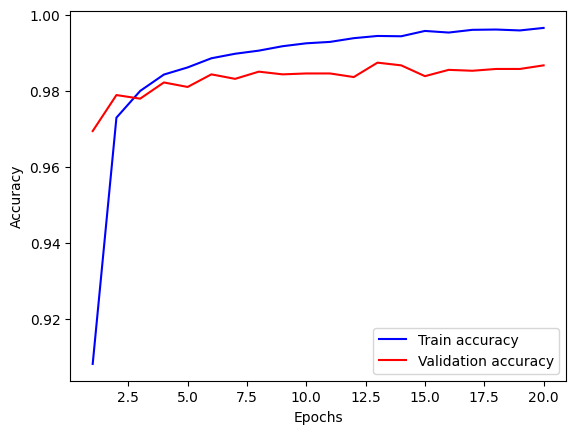

In [6]:
#%% Plot training and validation accuracies in epochs
plt.subplot()
plt.plot(np.arange(1, n_epochs+1), train_acc, 'b', label='Train accuracy')
plt.plot(np.arange(1, n_epochs+1), dev_acc, 'r', label='Validation accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

# Analysis of prediction results on validation data

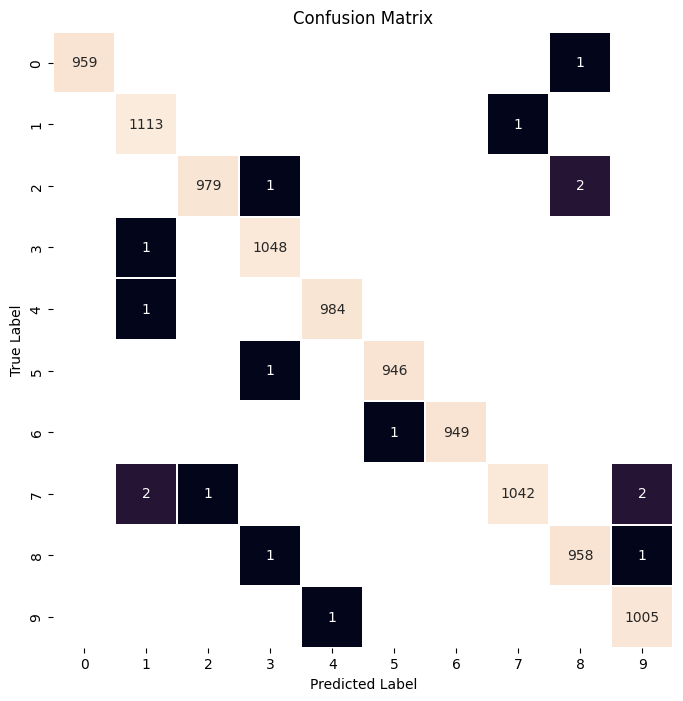

In [7]:
#%% Analysis of prediction results on dev data
indxs=np.arange(0,len(X))
random.shuffle(indxs)
out=model(torch.tensor(X[indxs[:10000]].reshape(-1,1,img_pix,img_pix), dtype=torch.float32))

predictions = torch.argmax(out, dim=1).numpy()
confusion_mtx = confusion_matrix(predictions, y[indxs[:10000]])

f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,  fmt= '1', ax=ax, norm=LogNorm(), cbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Evaluate the model on test data and save submission.cvs

In [8]:
#%% Evaluate the model on test data and save submission.cvs
test_data = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')
X_test=test_data.to_numpy(dtype='float')

#Train model on the validation dataset
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True)

for epoch in range(1, n_epochs+1):
    print("-------------\nEpoch {}:\n".format(epoch))
    loss, acc = run_epoch(X_dev_set, model.train(), optimizer, device, batch_size)
    print('Train loss: {:.6f} | Train accuracy: {:.6f}'.format(loss, acc))

# Scaling test data to [0, 1]
X_test=X_test/np.max(X_test)
X_test=X_test.reshape(-1, 1, img_pix, img_pix)

model_eval=model.eval()
out=model_eval(torch.tensor(X_test, dtype=torch.float32)) 
predict = torch.argmax(out, dim=1).numpy()
predictions = [int(x) for x in predict]

output = pd.DataFrame({'ImageId': range(1, len(X_test)+1), 'Label': predictions})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

-------------
Epoch 1:



100%|██████████| 132/132 [00:02<00:00, 60.98it/s]


Train loss: 0.079349 | Train accuracy: 0.982008
-------------
Epoch 2:



100%|██████████| 132/132 [00:02<00:00, 63.78it/s]


Train loss: 0.040340 | Train accuracy: 0.989347
-------------
Epoch 3:



100%|██████████| 132/132 [00:02<00:00, 59.87it/s]


Train loss: 0.027744 | Train accuracy: 0.993134
-------------
Epoch 4:



100%|██████████| 132/132 [00:02<00:00, 62.01it/s]


Train loss: 0.015701 | Train accuracy: 0.995502
-------------
Epoch 5:



100%|██████████| 132/132 [00:02<00:00, 48.77it/s]


Train loss: 0.012374 | Train accuracy: 0.998106
-------------
Epoch 6:



100%|██████████| 132/132 [00:02<00:00, 59.35it/s]


Train loss: 0.012159 | Train accuracy: 0.997159
-------------
Epoch 7:



100%|██████████| 132/132 [00:02<00:00, 57.45it/s]


Train loss: 0.009109 | Train accuracy: 0.998343
-------------
Epoch 8:



100%|██████████| 132/132 [00:02<00:00, 59.52it/s]


Train loss: 0.010053 | Train accuracy: 0.997869
-------------
Epoch 9:



100%|██████████| 132/132 [00:02<00:00, 61.32it/s]


Train loss: 0.007156 | Train accuracy: 0.998343
-------------
Epoch 10:



100%|██████████| 132/132 [00:02<00:00, 59.84it/s]


Train loss: 0.004446 | Train accuracy: 0.999763
-------------
Epoch 11:



100%|██████████| 132/132 [00:02<00:00, 59.29it/s]


Train loss: 0.004208 | Train accuracy: 0.999053
-------------
Epoch 12:



100%|██████████| 132/132 [00:02<00:00, 56.46it/s]


Train loss: 0.003560 | Train accuracy: 0.999527
-------------
Epoch 13:



100%|██████████| 132/132 [00:02<00:00, 53.63it/s]


Train loss: 0.003133 | Train accuracy: 0.999290
-------------
Epoch 14:



100%|██████████| 132/132 [00:02<00:00, 59.46it/s]


Train loss: 0.002514 | Train accuracy: 1.000000
-------------
Epoch 15:



100%|██████████| 132/132 [00:02<00:00, 57.14it/s]


Train loss: 0.001817 | Train accuracy: 0.999763
-------------
Epoch 16:



100%|██████████| 132/132 [00:02<00:00, 57.48it/s]


Train loss: 0.002753 | Train accuracy: 0.999290
-------------
Epoch 17:



100%|██████████| 132/132 [00:02<00:00, 59.27it/s]


Train loss: 0.001494 | Train accuracy: 0.999763
-------------
Epoch 18:



100%|██████████| 132/132 [00:02<00:00, 58.54it/s]


Train loss: 0.002634 | Train accuracy: 0.999527
-------------
Epoch 19:



100%|██████████| 132/132 [00:02<00:00, 47.44it/s]


Train loss: 0.002400 | Train accuracy: 0.999290
-------------
Epoch 20:



100%|██████████| 132/132 [00:02<00:00, 60.10it/s]


Train loss: 0.002657 | Train accuracy: 0.999290
Your submission was successfully saved!


# Plot several predicted examples

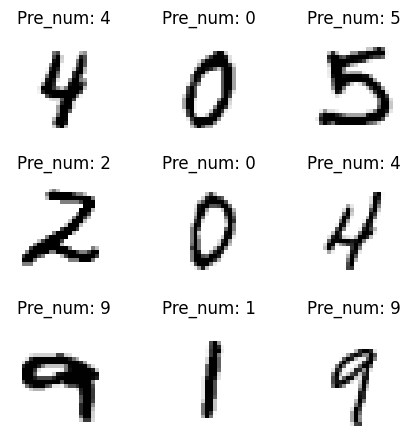

In [9]:
# repeat to show new digits in random order from X_test
plot_digits(X_test, img_pix, 3, labels_predict=predict)